# Scorecard

## 1. Importing packages, basic familiarisation with World Bank package

In [1]:
# https://pypi.org/project/world-bank-data/

In [2]:
# pip install world_bank_data --upgrade

In [3]:
# pip install voila

In [4]:
import pandas as pd
import world_bank_data as wb
import warnings 
import ipywidgets as widgets
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import scipy.stats as stats
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
import math
from functools import reduce
import plotly.express as px 
import matplotlib.pyplot as plt
from ipywidgets import interact,FloatSlider,IntSlider
from IPython.display import Javascript, display
from ipywidgets import widgets

warnings.filterwarnings('ignore') # suppress the warnings

# defining a function for a button, which will run all consecutive cells
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))


In [5]:
pd.set_option("display.precision", 2) # setting a precision
pd.options.display.float_format = '{:,.3f}'.format

### Geting the list of indicators
This is done with the get_indicators function. You may query only the indicators for a specific source or topic as below. If you input no arguments, the get_indicator function will return the description of all the 16,000+ indicators.

In [6]:
# get the indicators for everything under the agriculture topic
# topic and source id are from get_topics/get_sources - topic 1 is agriculture
agriculture = wb.get_indicators(topic=1) 
ag_indicator = agriculture.reset_index()
ag_indicator = ag_indicator[["id", "name", "sourceNote", "sourceOrganization"]]

## 2. Data import

### a. Latitude and longitude data + distance to Ireland calculation

In [7]:
# create a df with all country locations
countries_loc = wb.get_countries()

# filling in the missing latitudes and longitudes

# https://latitudelongitude.org/gi/gibraltar/
countries_loc['capitalCity'].loc['GIB'] = "Gibraltar";
countries_loc['latitude'].loc['GIB'] = 36.14474;
countries_loc['longitude'].loc['GIB'] = -5.35257;

# https://latitudelongitude.org/tw/taipei/
countries_loc['capitalCity'].loc['TWN'] = "Taipei";
countries_loc['latitude'].loc['TWN'] = 25.04776;
countries_loc['longitude'].loc['TWN'] = 121.53185;

# https://latitudelongitude.org/cw/willemstad/
countries_loc['latitude'].loc['CUW'] = 12.1084;
countries_loc['longitude'].loc['CUW'] = -68.93354;

# https://latitudelongitude.org/je/saint-helier/
countries_loc['capitalCity'].loc['CHI'] = "St. Helier";
countries_loc['latitude'].loc['CHI'] = 49.18804;
countries_loc['longitude'].loc['CHI'] = -2.10491;

# https://latitudelongitude.org/mf/marigot/
countries_loc['latitude'].loc['MAF'] = 18.06667;
countries_loc['longitude'].loc['MAF'] = -63.08333;

# https://latitudelongitude.org/ps/gaza/
countries_loc['capitalCity'].loc['PSE'] = "Gaza";
countries_loc['latitude'].loc['PSE'] = 31.5;
countries_loc['longitude'].loc['PSE'] = 34.46667;

# https://latitudelongitude.org/sx/philipsburg/
countries_loc['latitude'].loc['SXM'] = 18.026;
countries_loc['longitude'].loc['SXM'] = -63.04582;

countries_loc['capitalCity'].loc['HKG'] = "Victoria";
countries_loc['capitalCity'].loc['ISR'] = "Jerusalem";
countries_loc['capitalCity'].loc['MAC'] = "Macau";

# create a df with the removed rows the drop all rows with na values
nas = countries_loc[countries_loc['longitude'].isna()]
countries_loc = countries_loc.dropna(axis = 0, how ='any')

countries_loc.drop(axis=0, columns={"adminregion", "lendingType"}, inplace = True)
print(countries_loc.shape)

(218, 7)


In [8]:
# separate just the relevant data - latitude and longitude

long_lat = countries_loc[["name","longitude","latitude"]]
long_lat.head()

,name,longitude,latitude
id,,,
ABW,Aruba,-70.017,12.517
AFG,Afghanistan,69.176,34.523
AGO,Angola,13.242,-8.812
ALB,Albania,19.817,41.332
AND,Andorra,1.522,42.508


What we want to include in the scorecard is the distance from Ireland - we argue that the bigger the distance, the bigger problems with delivery

In calculation of Distance to Ireland, we selected Haversine distance as the most appropriate measure, since it allows us to calculate distance on a curved surface, such as on the surface of the Earth, in comparison e.g. to Euclidean distance which works on flat surfaces. 

Adapted code from the following source: https://janakiev.com/blog/gps-points-distance-python/

In [9]:
def haversine_to_IRL(lat1, lon1):
    R = 6372800  # Radius of the earth   
    
    lon_IRL = long_lat.loc['IRL'][1]
    lat_IRL = long_lat.loc['IRL'][2]

    phi1, phi2 = math.radians(lat1), math.radians(lat_IRL) 
    dphi       = math.radians(lat_IRL - lat1)
    dlambda    = math.radians(lon_IRL - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [10]:
long_lat['DistanceToIE'] = long_lat.apply(lambda row: haversine_to_IRL(row['latitude'], row['longitude']), axis = 1)
long_lat.rename(columns = {'name':'Country'}, inplace=True)
long_lat = long_lat.drop(columns=["latitude","longitude"])

We will later merge the distance data with the other data we pull from WorldBank

### b. Pulling scorecard data from WorldBank

We will pull the list of variables of interest from Worldbank and merge it into one dataframe

In [11]:
wb_list = ["TM.TAX.TCOM.WM.AR.ZS",'IC.IMP.TMBC','NY.GDP.MKTP.KD.ZG','NY.GDP.PCAP.PP.CD','FP.CPI.TOTL.ZG','SL.UEM.TOTL.NE.ZS','SP.POP.TOTL', 'NV.SRV.TOTL.ZS','IC.IMP.CSBC.CD']

In [12]:
x=0
    
for i in wb_list:
    if x ==0:
        wbdata = pd.DataFrame(wb.get_series(i)).reset_index()
        wbdata.drop(columns = "Series", inplace=True) #The series name is repetitive after the merge
        x = x + 1 # adding logic of first creating the dataframe, then joining the remaining columns
    
    else:
        wbdata_join = pd.DataFrame(wb.get_series(i)).reset_index()
        wbdata_join.drop(columns = "Series", inplace=True)
        wbdata = wbdata.merge(wbdata_join,on=['Country',"Year"])

In [13]:
wbdata = wbdata.dropna() 
wbdata.shape

(556, 11)

Data returned 556 rows and 11 columns after dropping NAs.

Since missing values in the WorldBank data indicate either governmental control or unstable political environment, we decided to drop these values rather than to fill it through other sources, as the dropped markets would not be a promising environment for export.

### c. Importing and cleaning the Risk data from Euler Hermes

In [14]:
risk = pd.read_csv("Country_Risk_EH.csv")
risk.head()

,Country,MediumTerm Rating (Country),Short-Term Rating (Country Risk Level)
0,Afghanistan,D,4
1,Albania,D,3
2,Algeria,C,3
3,American Samoa,A,1
4,Andorra,AA,1


Medium risk data, which came from Euler Hermes, needed to be encoded, since they were in a categorical format, ranging from AA to E - the values were encoded into a numerical format ranging from 0 to 1. We also renamed the columns to not contain brackets or spaces for easier work.

In [15]:
risk = risk.rename(columns={'MediumTerm Rating (Country)':'MediumTermRisk',
                            'Short-Term Rating (Country Risk Level)':'ShortTermRisk'})

Medium term rating is coded into 6 categorical values - we will need to encode them into a numerical format

In [16]:
encoding_medium_risk = {"AA":0,
                        "A":0.2,
                        "BB":0.4,
                        "B":0.6,
                        "C":0.8,
                        "c":0.8,
                        "D":1
                       }

In [17]:
risk['MediumTermRisk'] = risk['MediumTermRisk'].replace(encoding_medium_risk)
risk.head()

,Country,MediumTermRisk,ShortTermRisk
0,Afghanistan,1.000,4
1,Albania,1.000,3
2,Algeria,0.800,3
3,American Samoa,0.200,1
4,Andorra,0.000,1


Since data is coming from a different source, first we compare the naming of the countries with the WorldBank data and process renaming to get maximum of matches between data

In [18]:
wbcountry = wbdata['Country'].unique().tolist()
riskcountry = risk['Country'].unique().tolist()
#set(wbcountry) - set(riskcountry) #prints difference between dataframes
#note: code now hidden for visualisation purposes, but it was run when cleaning the data

We notice that some countreis contain commas and might be unusual when interpreting. We will drop the "The" and simplify the naming.

In [19]:
# wbdata['Country'].unique() - code now hidden for visualisation purposes, but it was run when cleaning the data

In [20]:
wb_dict = {
    'Bahamas, The':'Bahamas',
    'Egypt, Arab Rep.':'Egypt',
    'Gambia, The':'Gambia',
    'Iran, Islamic Rep.':'Iran',
    'Hong Kong SAR, China':'Hong Kong SAR',
    'Korea, Rep.':'South Korea',
    'Lao PDR':'Laos',
    'Timor-Leste':'Timor Leste'
}

In [21]:
wbdata['Country'] = wbdata['Country'].replace(wb_dict) #data renamed as per dictionary abive

In [22]:
#long_lat data shares the same structure, so we recode it as per the same dictionary
long_lat['Country'] = long_lat['Country'].replace(wb_dict)

We now print all values in the risk dataframe to compare naming with the wb_data dataframe differences and unify the naming where possible

In [23]:
#risk['Country'].unique() - code now hidden for visualisation purposes, but it was run when cleaning the data

In [24]:
risk_dict = {
    'Ban ladesh':'Bangladesh', #we notice some errors in words - missing letter
    'Egypt ':'Egypt', #space after the word will be deleted
    'Honk Kong SAR':'Hong Kong SAR',
    'Myanmar (Burma)':'Myanmar',
    "Cöte d'Ivoire":"Cote d'Ivoire", #unusual symbol will be deleted
    'Cape Verde Islands':'Cabo Verde',
    'Guinea (Rep Of)':'Guinea'
}

In [25]:
risk['Country'] = risk['Country'].replace(risk_dict)

In [26]:
wbcountry = wbdata['Country'].unique().tolist()
riskcountry = risk['Country'].unique().tolist()
set(wbcountry) - set(riskcountry)

{'European Union', 'West Bank and Gaza'}

In the end, we will drop European Union (aggregate) data and just one extra location, which seems to be a good result. 

### d. Bovine consumption data

Load the dataset. We notice very complex naming, which is why the columns are renamed to simpler terms. 

In [27]:
meat_cons = pd.read_csv("meat-consumption-per-capita-type.csv")
meat_cons = meat_cons.rename(columns = {"Entity":"Country",
                                        "New Food Balances - Poultry Meat - 2734 - Food supply quantity (kg/capita/yr) - 645 - kg": "Poultry",
                                       "New Food Balances - Bovine Meat - 2731 - Food supply quantity (kg/capita/yr) - 645 - kg":"Bovine",
                                        "New Food Balances - Pigmeat - 2733 - Food supply quantity (kg/capita/yr) - 645 - kg":"Pigmeat",
                                       "New Food Balances - Mutton & Goat Meat - 2732 - Food supply quantity (kg/capita/yr) - 645 - kg":"Mutton_Goat",
                                       "New Food Balances - Meat, Other - 2735 - Food supply quantity (kg/capita/yr) - 645 - kg":"Other",
                                       "New Food Balances - Fish, Seafood - 2960 - Food supply quantity (kg/capita/yr) - 645 - kg":"Fish"})
meat_cons.head()

,Country,Code,Year,Poultry,Bovine,Mutton_Goat,Pigmeat,Other,Fish
0,Afghanistan,AFG,2014,1.980,3.910,4.380,0.010,0.330,0.190
1,Afghanistan,AFG,2015,1.910,3.460,4.290,0.010,0.320,0.210
2,Afghanistan,AFG,2016,1.670,2.960,4.110,0.000,0.310,0.230
3,Afghanistan,AFG,2017,1.530,2.610,4.150,0.000,0.300,0.250
4,Albania,ALB,2014,13.790,18.210,11.900,7.420,0.000,5.340


We also create additional metric - total meat being sum of all other types of meat vs. bovine, and we also calculate the share of bovine out of all meat consumed. 

In [28]:
meat_cons["Total_Meat"] = meat_cons.iloc[:,-7:-1].sum(axis=1)
meat_cons["Bovine_Share"] = (meat_cons["Bovine"]/meat_cons["Total_Meat"])
meat_cons = meat_cons.drop(columns=["Bovine","Poultry","Mutton_Goat","Fish","Pigmeat","Other","Code"])

We conduct the same check for country naming as before and follow the same process

In [29]:
wbcountry = wbdata['Country'].unique().tolist()
meat_cons_country = meat_cons['Country'].unique().tolist()
# set(wbcountry) - set(meat_cons_country) - code now hidden for visualisation purposes, but it was run when cleaning the data

In [30]:
# meat_cons_country - code now hidden for visualisation purposes, but it was run when cleaning the data

In [31]:
meat_cons_dict = {
    'Cape Verde':'Cabo Verde',
    'Brunei':'Brunei Darussalam',
    'Czechia':'Czech Republic',
    'Hong Kong':'Hong Kong SAR',
    'Kyrgyzstan':'Kyrgyz Republic',
    'Russia':'Russian Federation',
    'Slovakia':'Slovak Republic',
    'Saint Lucia':'St. Lucia',
    'Timor':'Timor Leste' 
}

In [32]:
meat_cons['Country'] = meat_cons['Country'].replace(meat_cons_dict)

### e. Dairy consumption (per person per year)

Dairy consumption data is treated the same way as meat consumption - renaming columns, checking naming and unifying the naming. 

In [33]:
dairy_cons = pd.read_csv("milk-consumption-per-capita.csv")
dairy_cons = dairy_cons.rename(columns = {"Milk - Excluding Butter - Food supply quantity (kg/capita/yr) (FAO, 2020)":"Milk",
                               "Entity":"Country"}
                              )
dairy_cons.head()

,Country,Code,Year,Milk
0,Afghanistan,AFG,1961,59.300
1,Afghanistan,AFG,1962,58.570
2,Afghanistan,AFG,1963,63.870
3,Afghanistan,AFG,1964,64.050
4,Afghanistan,AFG,1965,68.620


In [34]:
wbcountry = wbdata['Country'].unique().tolist()
dairy_cons_country = dairy_cons['Country'].unique().tolist()
# set(wbcountry) - set(dairy_cons_country) - code now hidden for visualisation purposes, but it was run when cleaning the data

As per our check, it seems like the naming is the same for dairy and meat datasets, so we will apply the same dictionary from working with meat for renaming countries and cleaning the data. 

In [35]:
dairy_cons['Country'] = dairy_cons['Country'].replace(meat_cons_dict)

### f. Agriculture land

We include the agriculture land data and drop the unnecessary columns, then conduct the same check as before on the previous dataframes

In [36]:
agLand = pd.read_csv("agrLand_country_df.csv")
agLand.head()

,Unnamed: 0,id,iso2Code,Country,longitude,latitude,Year,Agr_land_sq_km,Agr_land_per
0,1,AFG,AF,Afghanistan,69.176,34.523,1961,"377,000.000",57.746
1,2,AFG,AF,Afghanistan,69.176,34.523,1962,"377,600.000",57.838
2,3,AFG,AF,Afghanistan,69.176,34.523,1963,"378,100.000",57.914
3,4,AFG,AF,Afghanistan,69.176,34.523,1964,"378,730.000",58.011
4,5,AFG,AF,Afghanistan,69.176,34.523,1965,"378,750.000",58.014


In [37]:
agLand['Country'] = agLand['Country'].replace(wb_dict)
agLand = agLand.drop(columns=['Unnamed: 0','iso2Code','longitude','latitude','Agr_land_sq_km'])

In [38]:
wbcountry = wbdata['Country'].unique().tolist()
agLand_country = agLand['Country'].unique().tolist()
set(wbcountry) - set(agLand_country)

{'European Union'}

In [39]:
# agLand['Country'].unique() - code now hidden for visualisation purposes, but it was run when cleaning the data

### g. Partner preference

In [40]:
partners = pd.read_csv("Export_Partner_Preference.csv")

Unnecessary columns "explanation" will be dropped, and the countries will be checked for naming. 

In [41]:
partners.drop(columns={'Explanation'}, inplace=True)
partners = partners.rename(columns={'Rank':'PartnerRank'})

In [42]:
# compare datasets vs. each other on country naming as above
wbcountry = wbdata['Country'].unique().tolist()
partners_country = partners['Country'].unique().tolist()
# set(wbcountry) - set(partners_country) - code now hidden for visualisation purposes, but it was run when cleaning the data

It seems like some of the naming issues are the same as we observed in the meat dataframe. We also add some other changes in a separate dictionary. 

In [43]:
partners['Country'] = partners['Country'].replace(meat_cons_dict)

In [44]:
partner_dict = {
    'Algeria ':'Algeria',
    "Cote dIvoire":"Cote d'Ivoire",
    'Guinea-Bissau':'Guinea'
}

In [45]:
partners['Country'] = partners['Country'].replace(partner_dict)

Recoding partner values to match the interval 0-1

In [46]:
encoding_partner_pref = {1:0.0,
                        2:0.2,
                        3:0.4,
                        4:0.6,
                        5:1.0,
                       }

In [47]:
partners['PartnerRank'] = partners['PartnerRank'].replace(encoding_partner_pref)

**

## 3. Merging datasets

In [48]:
wbdata['Year'] = wbdata['Year'].astype(int)

Below we can choose the year of the analysis - you can use the slider to make your choice. 
    
<span style='background-color:yellow'><b>To note:</b> To use this slider, use the Jupyter Notebook and click the button below

In [49]:
year = widgets.IntSlider(value=2017,min=2014,max=2018)
display(year)

IntSlider(value=2017, max=2018, min=2014)

In [50]:
# button will update all cells below and makes it easy for a non-technical audience to work with the code
button1 = widgets.Button(description="Update the year")
display(button1)
button1.on_click(run_all)


Button(description='Update the year', style=ButtonStyle())

In [51]:
filter_year = year.value #links the widget with a value for filtering
wbdata_select = wbdata[wbdata['Year']==filter_year] # we filter the data related to the slider above
wbdata_select.head()

,Country,Year,TM.TAX.TCOM.WM.AR.ZS,IC.IMP.TMBC,NY.GDP.MKTP.KD.ZG,NY.GDP.PCAP.PP.CD,FP.CPI.TOTL.ZG,SL.UEM.TOTL.NE.ZS,SP.POP.TOTL,NV.SRV.TOTL.ZS,IC.IMP.CSBC.CD
850,European Union,2017,1.840,1.620,2.814,"42,676.629",1.429,8.140,"446,186,344.000",65.140,30.296
3107,Albania,2017,1.260,10.000,3.802,"12,770.971",2.061,13.620,"2,873,457.000",47.970,77.300
3168,Algeria,2017,9.790,327.390,1.300,"11,737.401",5.591,13.570,"41,389,174.000",47.635,408.778
3534,Armenia,2017,1.650,2.538,7.500,"12,115.139",0.970,17.700,"2,944,789.000",50.765,0.000
3656,Australia,2017,0.620,39.000,2.296,"48,398.550",1.949,5.590,"24,601,860.000",67.015,525.000


In [52]:
# we first merge the data that are time-bound (will be merged based on country and year)

df_final = pd.merge(wbdata_select,agLand,on=['Country',"Year"], how='right')
df_final = df_final.dropna()

In [53]:
dfs = [risk, df_final, long_lat] #list of dataframes that are static

In [54]:
# we will now merge the dataframe with the static frames, like distance to Ireland..
df_final = reduce(lambda  left,right: pd.merge(left,right,on=['Country'], how='right'), dfs)
df_final = df_final.dropna()
#df_final['Country'].unique() #checking for the remaining countries
#code now hidden for visualisation purposes, but it was run when cleaning the data

Depending on our focus, we may not want to include meat or dairy, which can be changed in the if boolean values below

In [55]:
include_meat = True

In [56]:
include_dairy = True

In [57]:
if include_meat == True:
    df_final = pd.merge(df_final,meat_cons,on=['Country',"Year"], how='inner')
    df_final = df_final.dropna()
    df_final.shape
else:
    print("Merging with meat data skipped")

In [58]:
if include_dairy == True:
    df_final = pd.merge(df_final,dairy_cons,on=['Country',"Year"], how='inner')
    df_final = df_final.dropna()
    df_final.shape
else:
    print("Merging with dairy data skipped")

In [59]:
df_final.shape # checking final shape of the data

(84, 20)

Finally, we then add the information about the preferred partner. Missing values can be filled with 0, which represent "no information"

In [60]:
df_final = pd.merge(df_final,partners,on=['Country'], how='left')
df_final = df_final.fillna(1) #missing values can be filled with 1, which represent "no information"
df_final.shape

(84, 21)

For better understanding, we will rename the columns to better show what do the World Bank data signify

In [61]:
df_final.rename(columns={'TM.TAX.TCOM.WM.AR.ZS':'Tariff','IC.IMP.TMBC':'TimeToImport','NY.GDP.MKTP.KD.ZG':'GDPGrowth','NY.GDP.PCAP.PP.CD':'GDPppp','FP.CPI.TOTL.ZG':'Inflation','SL.UEM.TOTL.NE.ZS':'Unemployment','SP.POP.TOTL':'Population', 'Distance to Ireland':'DistanceToIE','NV.SRV.TOTL.ZS':'ServicesFromGDP','IC.IMP.CSBC.CD':'CostToImportBorder'},inplace=True)

## 4. Normalising data in the scorecard

#### Interactive way of checking histograms and also shapiro-wilk test

Visual analysis of the histogram suggests normal distribution of data, thus w e used the Shapiro-Wilk test test to test normality.

H0: Data is normal H1: Data is not normal

If the P value is > 0.05, we cannot reject the null and we assume tha data is normal

In [62]:
def shapiro_print(p):
    if p > 0.05:
        print("---------\np > 0.05, so we cannot reject the null hypothesis - data is normally distributed")
    else:
        print("---------\np < 0.05, so we reject the null hypothesis - data is NOT normally distributed")


In [63]:
@interact #interactive element lets us investigate different columns

def stats_normality(column=list(df_final.select_dtypes(include=['float64']).columns)): #filter just float columns
    sns.distplot(df_final[column]);
    qqplot(df_final[column], line='s')
    shapiro = stats.shapiro(df_final[column])
    print(shapiro)
    shapiro_print(shapiro.pvalue)

interactive(children=(Dropdown(description='column', options=('MediumTermRisk', 'ShortTermRisk', 'Year', 'Tari…

We first create a copy of the dataframe, in which we will replace the values by normalised ones

In [64]:
df_scores = df_final

Then we also remove some outliers by lowering or increasing the max values

For inflation: Internationally acceptable inflation is ca. 2%, so all values below 2% will be given the max score. Then we will use min-max normalisation, inverted. 

In [65]:
df_scores.loc[df_scores['Inflation'] < 2, 'Inflation'] = 2


For unemployment: Internationally acceptable normal unemployment is ca. 5%, so all values below 5% will be given the max score. Then we will use min-max normalisation, inverted.

In [66]:
df_scores.loc[df_scores['Unemployment'] < 5, 'Unemployment'] = 5

For population size: Due to very strong outliers, we will cut down the range

In [67]:
df_scores.loc[df_scores['Population'] > 400000000, 'Population'] = 400000000

After aplying the logic of which values should be max in our scorecard, we divide our data into these that should be just normalised and these that should be normalised and inverted

In [68]:
normal_minmax = ['Bovine_Share','Total_Meat','Milk','ServicesFromGDP','GDPGrowth','GDPppp','Population','PartnerRank']
inverted_minmax = ['Agr_land_per','CostToImportBorder','ShortTermRisk','MediumTermRisk','Tariff','TimeToImport','Inflation','Unemployment','DistanceToIE']

In [69]:
for col in normal_minmax:
    df_scores[col] = minmax_scale(df_scores[[col]])

for col in inverted_minmax:
    df_scores[col] = abs(minmax_scale(df_scores[[col]])-1)

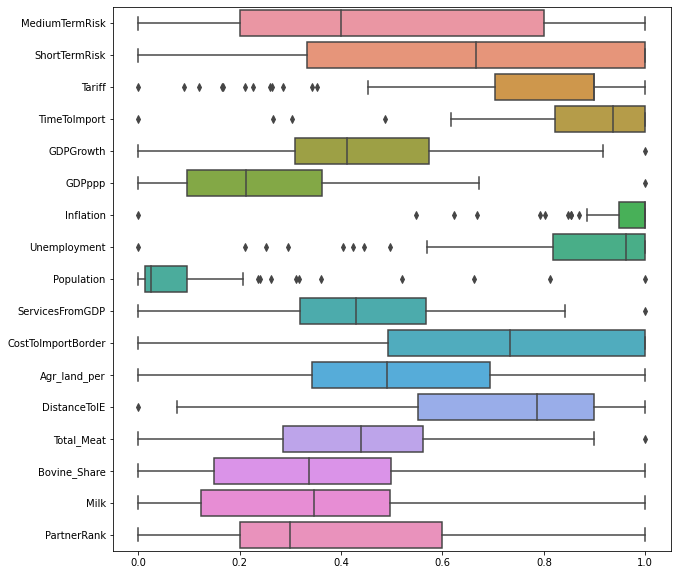

In [70]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df_scores.loc[:, df_scores.columns !='Year'], orient="h");

## 5. Scoring and weighing in Jupyter

To reflect different weighing approaches, you can pick one of four pre-defined approaches. Then, the user is given a chance to redefine weight to account for individual preferences or judgement. 

<span style='background-color:yellow'><b>To note:</b> To use this dropdown, use the Jupyter Notebook and click the button below. <br>You can also scroll down and visualise different approaches in the interactive map. 

In [71]:
approach = widgets.Dropdown(
    options=[('Traditional approach', 'tradition'), ('Partner approach', 'partner'), ('Cost-minimising approach', 'cost'), ('Balanced approach','balance')],
    value='tradition',
    description='Scoring:'        
)
display(approach)

Dropdown(description='Scoring:', options=(('Traditional approach', 'tradition'), ('Partner approach', 'partner…

In [72]:
#runs all cells below on click
button = widgets.Button(description="Apply scoring approach")
display(button)
button.on_click(run_all)

Button(description='Apply scoring approach', style=ButtonStyle())

The code predefines the weights associated with this approach to the interactive sliders. This make it easier to use the weights and adjust them slightly, rather than start from zero. 

In [73]:
if approach.value == "tradition":
    CostToImportBorder_W = 2
    DistanceToIE_W = 10
    Tariff_W = 7
    TimeToImport_W = 7
    Bovine_Share_W = 2
    Total_Meat_W = 2
    Milk_W = 2
    ShortTermRisk_W = 10
    MediumTermRisk_W = 2
    PartnersRank_W = 10
    Agr_land_per_W = 2
    GDPGrowth_W = 10
    GDPppp_W = 6
    Inflation_W = 5
    Population_W = 2
    ServicesFromGDP_W = 6
    Unemployment_W = 5

elif approach.value == "cost":
    CostToImportBorder_W = 8
    DistanceToIE_W = 10
    Tariff_W = 10
    TimeToImport_W = 4
    Bovine_Share_W = 2
    Total_Meat_W = 2
    Milk_W = 2
    ShortTermRisk_W = 5
    MediumTermRisk_W = 8
    PartnersRank_W = 7
    Agr_land_per_W = 2
    GDPGrowth_W = 8
    GDPppp_W = 2
    Inflation_W = 2
    Population_W = 10
    ServicesFromGDP_W = 6
    Unemployment_W = 2

elif approach.value == "partner":
    CostToImportBorder_W = 2
    DistanceToIE_W = 10
    Tariff_W = 2
    TimeToImport_W = 3
    Bovine_Share_W = 8
    Total_Meat_W = 8
    Milk_W = 8
    ShortTermRisk_W = 4
    MediumTermRisk_W = 10
    PartnersRank_W = 4
    Agr_land_per_W = 6
    GDPGrowth_W = 3
    GDPppp_W = 5
    Inflation_W = 3
    Population_W = 3
    ServicesFromGDP_W = 8
    Unemployment_W = 3

elif approach.value == "balance":
    CostToImportBorder_W = 7.5
    DistanceToIE_W = 7.5
    Tariff_W = 7.5
    TimeToImport_W = 7.5
    Bovine_Share_W = 5
    Total_Meat_W = 5
    Milk_W = 5
    ShortTermRisk_W = 5
    MediumTermRisk_W = 5
    PartnersRank_W = 5
    Agr_land_per_W = 4.285
    GDPGrowth_W = 4.285
    GDPppp_W = 4.285
    Inflation_W = 4.285
    Population_W = 4.285
    ServicesFromGDP_W = 4.285
    Unemployment_W = 4.285
    
else:
    print("Use valid option")

# for easy visibility, we sum weights of the different categories of features and print it below for the audience

MacroTotal = GDPGrowth_W + GDPppp_W + Inflation_W + Unemployment_W + Population_W + ServicesFromGDP_W + Agr_land_per_W
CultureTotal = Bovine_Share_W + Total_Meat_W + Milk_W 
PoliticsTotal = ShortTermRisk_W + MediumTermRisk_W + PartnersRank_W
ForeignTotal = CultureTotal + PoliticsTotal
CostTotal = Tariff_W + DistanceToIE_W + TimeToImport_W + CostToImportBorder_W

####

print("-------\nChosen approach: ",approach.value,"\n\n-------\nMACROECONOMIC FACTORS\nTotal weight: ",MacroTotal,"\n\n-------\nLIABILITY OF FOREIGNNESS\nTotal weight: ",ForeignTotal,"\na. Weight of cultural / habitual factors: ",CultureTotal,"\nb. Weight of political / business factors: ",PoliticsTotal, "\n\n-------\nCOST OF DOING BUSINESS ABROAD\nTotal weight: ",CostTotal)
      

-------
Chosen approach:  tradition 

-------
MACROECONOMIC FACTORS
Total weight:  36 

-------
LIABILITY OF FOREIGNNESS
Total weight:  28 
a. Weight of cultural / habitual factors:  6 
b. Weight of political / business factors:  22 

-------
COST OF DOING BUSINESS ABROAD
Total weight:  26


We also give the user of this dashboard a choice to apply manual weights to the scoring, with the help of the predefined approaches. This is a voluntary step, which makes the scorecard more applicable to all audiences. 

<span style='background-color:yellow'><b>To note:</b> To use these sliders, use the Jupyter Notebook and click the button below (after selecting manual weights)

In [74]:
style = {'description_width': 'initial'} # description of the sliders is too long, prolonging as per documentation

# below we assign the value of the widget to a variable, which we use for the multiplication and weighing
CostToImportBorder = widgets.IntSlider(min=0, max=10, value=CostToImportBorder_W, description="Cost to Import", style=style)
DistanceToIE = widgets.IntSlider(min=0, max=10, value=DistanceToIE_W , description="Distance to Ireland", style=style)
Tariff = widgets.IntSlider(min=0, max=10, value=Tariff_W, description="Tariff", style=style)
TimeToImport = widgets.IntSlider(min=0, max=10, value=TimeToImport_W, description="Time to Import", style=style)
Bovine_Share = widgets.IntSlider(min=0, max=10, value=Bovine_Share_W, description="Bovine Share", style=style)
Total_Meat = widgets.IntSlider(min=0, max=10, value=Total_Meat_W, description="Meat Consumption", style=style)
Milk = widgets.IntSlider(min=0, max=10, value=Milk_W, description="Milk Consumption", style=style)
ShortTermRisk = widgets.IntSlider(min=0, max=10, value=ShortTermRisk_W, description="Short Term Risk", style=style)
MediumTermRisk = widgets.IntSlider(min=0, max=10, value=MediumTermRisk_W, description="Medium Term Risk", style=style)
PartnersRank = widgets.IntSlider(min=0, max=10, value=PartnersRank_W, description="Partner Rank", style=style)
Agr_land_per = widgets.IntSlider(min=0, max=10, value=Agr_land_per_W, description="Agricultural land", style=style)
GDPGrowth = widgets.IntSlider(min=0, max=10, value=GDPGrowth_W, description="GDP Growth", style=style)
GDPppp = widgets.IntSlider(min=0, max=10, value=GDPppp_W, description="Purchasing Power Parity", style=style)
Inflation = widgets.IntSlider(min=0, max=10, value=Inflation_W, description="Inflation", style=style)
Population = widgets.IntSlider(min=0, max=10, value=Population_W, description="Population", style=style)
ServicesFromGDP = widgets.IntSlider(min=0, max=10, value=ServicesFromGDP_W, description="Inflation", style=style)
Unemployment = widgets.IntSlider(min=0, max=10, value=Unemployment_W, description="Population", style=style)

# display the sliders by category, while using the predefined weights
print("---------------------------------------------\nCost of Doing Business Abroad")
display(CostToImportBorder,DistanceToIE, Tariff, TimeToImport)

print("---------------------------------------------\nLiability of Foreigness: Cultural / Habitual")
display(Bovine_Share, Total_Meat, Milk)

print("---------------------------------------------\nLiability of Foreigness: Political / Business")
display(ShortTermRisk,MediumTermRisk, PartnersRank)

print("---------------------------------------------\nMacroeconomic Factors")
display(Agr_land_per, GDPGrowth, GDPppp, Inflation, Population, ServicesFromGDP, Unemployment)

---------------------------------------------
Cost of Doing Business Abroad


IntSlider(value=2, description='Cost to Import', max=10, style=SliderStyle(description_width='initial'))

IntSlider(value=10, description='Distance to Ireland', max=10, style=SliderStyle(description_width='initial'))

IntSlider(value=7, description='Tariff', max=10, style=SliderStyle(description_width='initial'))

IntSlider(value=7, description='Time to Import', max=10, style=SliderStyle(description_width='initial'))

---------------------------------------------
Liability of Foreigness: Cultural / Habitual


IntSlider(value=2, description='Bovine Share', max=10, style=SliderStyle(description_width='initial'))

IntSlider(value=2, description='Meat Consumption', max=10, style=SliderStyle(description_width='initial'))

IntSlider(value=2, description='Milk Consumption', max=10, style=SliderStyle(description_width='initial'))

---------------------------------------------
Liability of Foreigness: Political / Business


IntSlider(value=10, description='Short Term Risk', max=10, style=SliderStyle(description_width='initial'))

IntSlider(value=2, description='Medium Term Risk', max=10, style=SliderStyle(description_width='initial'))

IntSlider(value=10, description='Partner Rank', max=10, style=SliderStyle(description_width='initial'))

---------------------------------------------
Macroeconomic Factors


IntSlider(value=2, description='Agricultural land', max=10, style=SliderStyle(description_width='initial'))

IntSlider(value=10, description='GDP Growth', max=10, style=SliderStyle(description_width='initial'))

IntSlider(value=6, description='Purchasing Power Parity', max=10, style=SliderStyle(description_width='initial…

IntSlider(value=5, description='Inflation', max=10, style=SliderStyle(description_width='initial'))

IntSlider(value=2, description='Population', max=10, style=SliderStyle(description_width='initial'))

IntSlider(value=6, description='Inflation', max=10, style=SliderStyle(description_width='initial'))

IntSlider(value=5, description='Population', max=10, style=SliderStyle(description_width='initial'))

In [75]:
# user can run the code below and get a recounted table as per their selections
button2 = widgets.Button(description="Apply manual weights")
display(button2)
button2.on_click(run_all)

Button(description='Apply manual weights', style=ButtonStyle())

Then we calculate the final scores (weight * score) into the df_scores dataframe and also group categories together

In [76]:
df_scores['Macroeconomic Score'] = df_scores['GDPGrowth']*GDPGrowth.value + df_scores['GDPppp']*GDPppp.value + df_scores['Inflation']*Inflation.value + df_scores['Unemployment']*Unemployment.value + df_scores['Population']*Population.value + df_scores['Agr_land_per'] * Agr_land_per.value + df_scores['ServicesFromGDP'] * ServicesFromGDP.value

df_scores['Liability of Foreignness: Cultural Score'] = 0

if include_meat == True: 
    df_scores['Liability of Foreignness: Cultural Score'] = df_scores['Liability of Foreignness: Cultural Score'] + df_scores['Bovine_Share'] * Bovine_Share.value + df_scores['Total_Meat'] * Total_Meat.value
if include_dairy == True:
    df_scores['Liability of Foreignness: Cultural Score'] = df_scores['Liability of Foreignness: Cultural Score'] + df_scores['Milk'] * Milk.value

df_scores['Liability of Foreignness: Political Score'] = df_scores['MediumTermRisk']* MediumTermRisk.value + df_scores['ShortTermRisk'] * ShortTermRisk.value + df_scores['PartnerRank'] * PartnersRank.value

df_scores['Liability of Foreignness'] = df_scores['Liability of Foreignness: Cultural Score']  + df_scores['Liability of Foreignness: Political Score']

df_scores['Cost of Doing Business Abroad Score'] = df_scores['Tariff']*Tariff.value + df_scores['TimeToImport']*TimeToImport.value + df_scores['DistanceToIE']*DistanceToIE.value + df_scores['CostToImportBorder'] * CostToImportBorder.value

# since export score is a sum of all categories, summing them all together
df_scores['Export Score'] = df_scores['Liability of Foreignness'] + df_scores['Macroeconomic Score'] + df_scores['Cost of Doing Business Abroad Score']
# rounding for nicer numbers
df_scores['Export Score'] = round(df_scores['Export Score'], 2)


In [77]:
# the code below is for replicability - if the user changes values above or wants to come back to histogram
df_final_scores = df_scores[['Country','id','Macroeconomic Score','Liability of Foreignness', 'Liability of Foreignness: Cultural Score', 'Liability of Foreignness: Political Score','Cost of Doing Business Abroad Score','Export Score']].copy()
df_scores = df_scores.drop(columns=['Macroeconomic Score','Liability of Foreignness', 'Liability of Foreignness: Cultural Score', 'Liability of Foreignness: Political Score','Cost of Doing Business Abroad Score','Export Score'])



### Scores based on personalized scales - in a tabular form, executable in Jupyter

The weights below reflect the sliders the user customised and executed above, which gives the highest personalisation benefit. 

We also add filtering and sorting option to the final dataframe listing the scores (total and per category). Code inspired by: https://www.wrighters.io/use-ipywidgets-with-jupyter-notebooks/

In [78]:
columns_dropdown = widgets.Dropdown(
    options=df_final_scores.columns,
    value=df_final_scores.columns[6],
    description='Sort by column:',
    style=style)

top_x = widgets.IntSlider(
    value=10,
    min=0,
    max=len(df_final),
    description='Show x results:',
    style=style)

sort_checkbox = widgets.Checkbox(
    value=False,
    description='Check if ascending order',
    style=style)

#### Final scores as below, the higher the score the better:

In [79]:
from ipywidgets import interactive

def filter_table(columns_select,check_ascending,top):
    top10 = df_final_scores.sort_values(by=[columns_select],ascending=check_ascending).head(top)
    display(top10)

interactive(filter_table, columns_select = columns_dropdown, top = top_x, check_ascending = sort_checkbox)

interactive(children=(Dropdown(description='Sort by column:', index=6, options=('Country', 'id', 'Macroeconomi…

-----------------------------------

# -- Interactive map and table - prepared for Voilà --

To enable dropdown visualisation of different approaches, we also manually code them in the "scores_final" dataframe, as per approach that the stakeholder can select in the map.

Here, the stakeholder does not have an option to create custom weights, but can use the predefined approaches. If the stakeholder wants to use individual weights, we recommend to use the sliders above and execute cells in Jupyter. 

This code works in Voila. 

In [80]:
df_final_scores.set_index('id',drop=False,inplace=True)

Not to pollute original dataframe, we create copies that will be used for the visualisation

In [81]:
df_tradition = df_scores.copy()
df_cost = df_scores.copy()
df_partner = df_scores.copy()
df_balance = df_scores.copy()

We use the same logic for scoring as when creating the table

In [82]:
## Traditional

CostToImportBorder_W = 2
DistanceToIE_W = 10
Tariff_W = 7
TimeToImport_W = 7
Bovine_Share_W = 2
Total_Meat_W = 2
Milk_W = 2
ShortTermRisk_W = 10
MediumTermRisk_W = 2
PartnersRank_W = 10
Agr_land_per_W = 2
GDPGrowth_W = 10
GDPppp_W = 6
Inflation_W = 5
Population_W = 2
ServicesFromGDP_W = 6
Unemployment_W = 5

df_tradition['Macroeconomic Score'] = df_scores['GDPGrowth']*GDPGrowth_W + df_scores['GDPppp']*GDPppp_W + df_scores['Inflation']*Inflation_W + df_scores['Unemployment']*Unemployment_W + df_scores['Population']*Population_W + df_scores['Agr_land_per'] * Agr_land_per_W + df_scores['ServicesFromGDP'] * ServicesFromGDP_W
df_tradition['Liability of Foreignness: Cultural Score'] = 0
if include_meat == True: 
        df_tradition['Liability of Foreignness: Cultural Score'] = df_tradition['Liability of Foreignness: Cultural Score'] + df_scores['Bovine_Share'] * Bovine_Share_W + df_scores['Total_Meat'] * Total_Meat_W
if include_dairy == True:
        df_tradition['Liability of Foreignness: Cultural Score'] = df_tradition['Liability of Foreignness: Cultural Score'] + df_scores['Milk'] * Milk_W
df_tradition['Liability of Foreignness: Political Score'] = df_scores['MediumTermRisk']* MediumTermRisk_W + df_scores['ShortTermRisk'] * ShortTermRisk_W + df_scores['PartnerRank'] * PartnersRank_W
df_tradition['Liability of Foreignness'] = df_tradition['Liability of Foreignness: Cultural Score']  + df_tradition['Liability of Foreignness: Political Score']
df_tradition['Cost of Doing Business Abroad Score'] = df_scores['Tariff']*Tariff_W + df_scores['TimeToImport']*TimeToImport_W + df_scores['DistanceToIE']*DistanceToIE_W + df_scores['CostToImportBorder'] * CostToImportBorder_W
    # since export score is a sum of all categories, summing them all together
df_tradition['Export Score'] = df_tradition['Liability of Foreignness'] + df_tradition['Macroeconomic Score'] + df_tradition['Cost of Doing Business Abroad Score']
    # rounding for nicer numbers
df_tradition['Export Score'] = round(df_tradition['Export Score'], 2)
df_final['Export Score - Traditional'] = df_tradition['Export Score']

## Cost
CostToImportBorder_W = 8
DistanceToIE_W = 10
Tariff_W = 10
TimeToImport_W = 4
Bovine_Share_W = 2
Total_Meat_W = 2
Milk_W = 2
ShortTermRisk_W = 5
MediumTermRisk_W = 8
PartnersRank_W = 7
Agr_land_per_W = 2
GDPGrowth_W = 8
GDPppp_W = 2
Inflation_W = 2
Population_W = 10
ServicesFromGDP_W = 6
Unemployment_W = 2

df_cost['Macroeconomic Score'] = df_scores['GDPGrowth']*GDPGrowth_W + df_scores['GDPppp']*GDPppp_W + df_scores['Inflation']*Inflation_W + df_scores['Unemployment']*Unemployment_W + df_scores['Population']*Population_W + df_scores['Agr_land_per'] * Agr_land_per_W + df_scores['ServicesFromGDP'] * ServicesFromGDP_W
df_cost['Liability of Foreignness: Cultural Score'] = 0
if include_meat == True: 
        df_cost['Liability of Foreignness: Cultural Score'] = df_cost['Liability of Foreignness: Cultural Score'] + df_scores['Bovine_Share'] * Bovine_Share_W + df_scores['Total_Meat'] * Total_Meat_W
if include_dairy == True:
        df_cost['Liability of Foreignness: Cultural Score'] = df_cost['Liability of Foreignness: Cultural Score'] + df_scores['Milk'] * Milk_W
df_cost['Liability of Foreignness: Political Score'] = df_scores['MediumTermRisk']* MediumTermRisk_W + df_scores['ShortTermRisk'] * ShortTermRisk_W + df_scores['PartnerRank'] * PartnersRank_W
df_cost['Liability of Foreignness'] = df_cost['Liability of Foreignness: Cultural Score']  + df_cost['Liability of Foreignness: Political Score']
df_cost['Cost of Doing Business Abroad Score'] = df_scores['Tariff']*Tariff_W + df_scores['TimeToImport']*TimeToImport_W + df_scores['DistanceToIE']*DistanceToIE_W + df_scores['CostToImportBorder'] * CostToImportBorder_W
    # since export score is a sum of all categories, summing them all together
df_cost['Export Score'] = df_cost['Liability of Foreignness'] + df_cost['Macroeconomic Score'] + df_cost['Cost of Doing Business Abroad Score']
    # rounding for nicer numbers
df_final['Export Score - Cost'] = round(df_cost['Export Score'], 2)


## Partner

CostToImportBorder_W = 2
DistanceToIE_W = 10
Tariff_W = 2
TimeToImport_W = 3
Bovine_Share_W = 8
Total_Meat_W = 8
Milk_W = 8
ShortTermRisk_W = 4
MediumTermRisk_W = 10
PartnersRank_W = 4
Agr_land_per_W = 6
GDPGrowth_W = 3
GDPppp_W = 5
Inflation_W = 3
Population_W = 3
ServicesFromGDP_W = 8
Unemployment_W = 3

df_partner['Macroeconomic Score'] = df_scores['GDPGrowth']*GDPGrowth_W + df_scores['GDPppp']*GDPppp_W + df_scores['Inflation']*Inflation_W + df_scores['Unemployment']*Unemployment_W + df_scores['Population']*Population_W + df_scores['Agr_land_per'] * Agr_land_per_W + df_scores['ServicesFromGDP'] * ServicesFromGDP_W
df_partner['Liability of Foreignness: Cultural Score'] = 0
if include_meat == True: 
        df_partner['Liability of Foreignness: Cultural Score'] = df_partner['Liability of Foreignness: Cultural Score'] + df_scores['Bovine_Share'] * Bovine_Share_W + df_scores['Total_Meat'] * Total_Meat_W
if include_dairy == True:
        df_partner['Liability of Foreignness: Cultural Score'] = df_partner['Liability of Foreignness: Cultural Score'] + df_scores['Milk'] * Milk_W
df_partner['Liability of Foreignness: Political Score'] = df_scores['MediumTermRisk']* MediumTermRisk_W + df_scores['ShortTermRisk'] * ShortTermRisk_W + df_scores['PartnerRank'] * PartnersRank_W
df_partner['Liability of Foreignness'] = df_partner['Liability of Foreignness: Cultural Score']  + df_partner['Liability of Foreignness: Political Score']
df_partner['Cost of Doing Business Abroad Score'] = df_scores['Tariff']*Tariff_W + df_scores['TimeToImport']*TimeToImport_W + df_scores['DistanceToIE']*DistanceToIE_W + df_scores['CostToImportBorder'] * CostToImportBorder_W
    # since export score is a sum of all categories, summing them all together
df_partner['Export Score'] = df_partner['Liability of Foreignness'] + df_partner['Macroeconomic Score'] + df_partner['Cost of Doing Business Abroad Score']
    # rounding for nicer numbers
df_final['Export Score - Partner'] = round(df_partner['Export Score'], 2)


## Balance

CostToImportBorder_W = 7.5
DistanceToIE_W = 7.5
Tariff_W = 7.5
TimeToImport_W = 7.5
Bovine_Share_W = 5
Total_Meat_W = 5
Milk_W = 5
ShortTermRisk_W = 5
MediumTermRisk_W = 5
PartnersRank_W = 5
Agr_land_per_W = 4.285
GDPGrowth_W = 4.285
GDPppp_W = 4.285
Inflation_W = 4.285
Population_W = 4.285
ServicesFromGDP_W = 4.285
Unemployment_W = 4.285

df_balance['Macroeconomic Score'] = df_scores['GDPGrowth']*GDPGrowth_W + df_scores['GDPppp']*GDPppp_W + df_scores['Inflation']*Inflation_W + df_scores['Unemployment']*Unemployment_W + df_scores['Population']*Population_W + df_scores['Agr_land_per'] * Agr_land_per_W + df_scores['ServicesFromGDP'] * ServicesFromGDP_W
df_balance['Liability of Foreignness: Cultural Score'] = 0
if include_meat == True: 
        df_balance['Liability of Foreignness: Cultural Score'] = df_balance['Liability of Foreignness: Cultural Score'] + df_scores['Bovine_Share'] * Bovine_Share_W + df_scores['Total_Meat'] * Total_Meat_W
if include_dairy == True:
        df_balance['Liability of Foreignness: Cultural Score'] = df_balance['Liability of Foreignness: Cultural Score'] + df_scores['Milk'] * Milk_W
df_balance['Liability of Foreignness: Political Score'] = df_scores['MediumTermRisk']* MediumTermRisk_W + df_scores['ShortTermRisk'] * ShortTermRisk_W + df_scores['PartnerRank'] * PartnersRank_W
df_balance['Liability of Foreignness'] = df_balance['Liability of Foreignness: Cultural Score']  + df_balance['Liability of Foreignness: Political Score']
df_balance['Cost of Doing Business Abroad Score'] = df_scores['Tariff']*Tariff_W + df_scores['TimeToImport']*TimeToImport_W + df_scores['DistanceToIE']*DistanceToIE_W + df_scores['CostToImportBorder'] * CostToImportBorder_W
    # since export score is a sum of all categories, summing them all together
df_balance['Export Score'] = df_balance['Liability of Foreignness'] + df_balance['Macroeconomic Score'] + df_balance['Cost of Doing Business Abroad Score']
    # rounding for nicer numbers
df_final['Export Score - Balance'] = round(df_balance['Export Score'], 2)

Now we create a dropdown, based on which the weighed approach will be applied to the map

In [83]:
# dropdown that enables picking the approach, based on which it allocates the weights
approach2 = widgets.Dropdown(
    options=[('Traditional approach', 'Export Score - Traditional'), ('Partner approach', 'Export Score - Partner'), ('Cost-minimising approach', 'Export Score - Cost'), ('Balanced approach','Export Score - Balance')],
    value="Export Score - Traditional",
    description='Approach'        
)

In [84]:
def map(Scope='world', pokus = "Export Score"):

    fig = px.choropleth(df_final, 
                        locations="id",
                        color=pokus,
                        hover_name="Country",
                        color_continuous_scale=px.colors.sequential.Greens,
                        title=("Calculated score of export potential for agricultural products"),
                        scope = Scope,
                        hover_data={"Export Score - Traditional":':,.2s',
                                    "Export Score - Partner":':,.2s',
                                    "Export Score - Balance":':,.2s',
                                    "Export Score - Cost":':,.2s'}
                       )

    fig.update_layout(
        margin=dict(l=0, r=0, t=50, b=20),

        annotations = [dict(
            x = 0.5,
            y = -0.02,
            text = "",
            showarrow = False
        )])

    fig.show() 

In [85]:
# adding a widget to select a region and easily zoom on the map
widgets.interact(map,
                 Scope=[('Whole world','world'),('Africa','africa'),('Asia','asia'),('Europe','europe'),('North America','north america'),('South America','south america')], pokus = approach2);



interactive(children=(Dropdown(description='Scope', options=(('Whole world', 'world'), ('Africa', 'africa'), (…

In [86]:
df_final.set_index('Country',drop=False,inplace=True)

In [88]:
from ipywidgets import interactive

def filter_table(Sorting,check_ascending,top):
    top10 = df_final.filter(regex=' - ').sort_values(by=[Sorting],ascending=check_ascending).head(top)
    display(top10)

interactive(filter_table, Sorting = df_final.filter(regex=' - '), top = top_x, check_ascending = sort_checkbox)

interactive(children=(Dropdown(description='Sorting', options=('Export Score - Traditional', 'Export Score - C…